In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


In [38]:
df = pd.read_csv('/content/Speech Pathology Detection.csv')

# Data Inspection

In [39]:
# Data Summary
print("Dataset Shape:", df.shape)
print("\nColumn Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicate Rows:")
print(f"Total duplicate rows: {df.duplicated().sum()}")
print(f"Duplicate filenames: {df['filename'].duplicated().sum()}")
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (2035, 32)

Column Types:
Unnamed: 0              int64
filename               object
chroma_stft           float64
rmse                  float64
spectral_centroid     float64
spectral_bandwidth    float64
rolloff               float64
zero_crossing_rate    float64
mfcc1                 float64
mfcc2                 float64
mfcc3                 float64
mfcc4                 float64
mfcc5                 float64
mfcc6                 float64
mfcc7                 float64
mfcc8                 float64
mfcc9                 float64
mfcc10                float64
mfcc11                float64
mfcc12                float64
mfcc13                float64
mfcc14                float64
mfcc15                float64
mfcc16                float64
mfcc17                float64
mfcc18                float64
mfcc19                float64
mfcc20                float64
label                  object
ID                      int64
G                      object
A                       int64

In [40]:
# Checking for consistencies

print("Gender value counts:")
print(df['G'].value_counts())

print(f"\nStatus Change:")
print(df['label'].value_counts())

print(f"\nFilename consistency check")
print(f"Total files: {len(df)}")
print(f"Files with '-a_h.wav' pattern: {df['filename'].str.contains('-a_h.wav').sum()}")

Gender value counts:
G
w    1155
m     880
Name: count, dtype: int64

Status Change:
label
Unhealthy    1348
Healthy       687
Name: count, dtype: int64

Filename consistency check
Total files: 2035
Files with '-a_h.wav' pattern: 2035


In [41]:
# Comprehensive age validation
age_issues = df[
    (df['A'] < 0) |           # Negative ages
    (df['A'] > 120) |         # Unrealistically high ages
    (df['A'].isna()) |        # Missing values
    (df['A'] % 1 != 0)        # Non-integer ages
]

if len(age_issues) > 0:
    print(f"\nSuspicious age values: {len(age_issues)}")
    print("\nDetails of suspicious ages:")
    print(age_issues[['A']].value_counts().sort_index())

    # Detailed breakdown by type
    negative_ages = len(df[df['A'] < 0])
    too_high_ages = len(df[df['A'] > 120])
    missing_ages = len(df[df['A'].isna()])
    non_integer_ages = len(df[df['A'] % 1 != 0])

    print(f"\nResults:")
    print(f"  Negative ages: {negative_ages}")
    print(f"  Ages > 120: {too_high_ages}")
    print(f"  Missing values: {missing_ages}")
    print(f"  Non-integer ages: {non_integer_ages}")
else:
    print("\nNo suspicious age values found.")


No suspicious age values found.


# Data Cleaning

In [42]:
df.head()

,Unnamed: 0,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,ID,G,A
0,0,1-a_h.wav,0.127341,0.355538,1587.507015,2002.198851,2737.971816,0.066798,-233.566208,48.504421,...,-28.190628,1.143172,4.134034,52.794827,39.092403,49.037060,Healthy,1,w,20
1,1,10-a_h.wav,0.215317,0.250342,1272.900724,1850.302841,1692.919922,0.043325,-179.419601,119.705742,...,7.790230,-7.037875,-9.193601,11.183559,-2.173607,-9.420938,Healthy,10,w,22
2,2,100-a_h.wav,0.212512,0.251419,919.203795,1014.718104,1275.967478,0.047079,-209.186188,167.135651,...,-20.040691,-4.153456,-2.725145,-10.669723,-2.336876,7.741264,Healthy,100,m,66
3,3,1000-a_h.wav,0.198861,0.157396,1119.517351,1529.490600,1501.657586,0.045487,-210.244278,139.819519,...,-0.163550,7.797343,-26.314997,-6.622046,0.535120,0.749695,Healthy,1000,m,31
4,4,1002-a_h.wav,0.370113,0.143538,1060.678054,1346.299507,1524.942294,0.050109,-175.039948,181.905212,...,-20.939833,13.306650,-26.597456,-8.324528,10.786009,-6.677513,Healthy,1002,m,25


In [43]:
# Drop irrelevant column (unnamed)
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [44]:
# Convert all column names to lowercase for consistency throughout the dataframe
df.columns = df.columns.str.lower()

In [45]:
# Rename columns
df = df.rename(columns={
    'label': 'status',
    'g': 'gender',
    'a': 'age'
})

In [46]:
# Find the min and max ages for age binning
print(f"Maximum age: {df['age'].max()}")
print(f"Minimum age: {df['age'].min()}")

# Create bins to cover up to 100 years
bin_edges = [0, 12, 24, 36, 48, 60, 72, 84, 100]
bin_labels = ['0-12', '12-24', '24-36', '36-48', '48-60', '60-72', '72-84', '85+']

df['age_group'] = pd.cut(df['age'], bins=bin_edges, labels=bin_labels, include_lowest=True)

print(df['age_group'].value_counts().sort_index())

Maximum age: 94
Minimum age: 9
age_group
0-12       8
12-24    513
24-36    348
36-48    324
48-60    419
60-72    340
72-84     79
85+        4
Name: count, dtype: int64


In [47]:
# Change gender 'w' and 'm' to 1 and 0
df['gender_encoded'] = df['gender'].map({'w': 1, 'm': 0})

In [48]:
# Reordering dataframe
new_order = ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
             'rolloff', 'zero_crossing_rate', 'mfcc1',
             'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6',
             'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
             'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19',
             'mfcc20', 'id', 'status', 'gender', 'gender_encoded', 'age_group', 'age']

df = df[new_order]
df.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc17,mfcc18,mfcc19,mfcc20,id,status,gender,gender_encoded,age_group,age
0,1-a_h.wav,0.127341,0.355538,1587.507015,2002.198851,2737.971816,0.066798,-233.566208,48.504421,-34.518085,...,4.134034,52.794827,39.092403,49.037060,1,Healthy,w,1,12-24,20
1,10-a_h.wav,0.215317,0.250342,1272.900724,1850.302841,1692.919922,0.043325,-179.419601,119.705742,0.882231,...,-9.193601,11.183559,-2.173607,-9.420938,10,Healthy,w,1,12-24,22
2,100-a_h.wav,0.212512,0.251419,919.203795,1014.718104,1275.967478,0.047079,-209.186188,167.135651,-37.398190,...,-2.725145,-10.669723,-2.336876,7.741264,100,Healthy,m,0,60-72,66
3,1000-a_h.wav,0.198861,0.157396,1119.517351,1529.490600,1501.657586,0.045487,-210.244278,139.819519,-7.774013,...,-26.314997,-6.622046,0.535120,0.749695,1000,Healthy,m,0,24-36,31
4,1002-a_h.wav,0.370113,0.143538,1060.678054,1346.299507,1524.942294,0.050109,-175.039948,181.905212,-33.181606,...,-26.597456,-8.324528,10.786009,-6.677513,1002,Healthy,m,0,24-36,25


# Export cleaned data



In [49]:
from google.colab import files

# Export as Excel
df.to_excel('cleaned_speech_pathology.xlsx')
files.download('cleaned_speech_pathology.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Visualisation

In [50]:
df.status.value_counts()/len(df)*100

,count
status,
Unhealthy,66.240786
Healthy,33.759214


In [51]:
# Count men and women
gender_counts = df['gender'].value_counts()
print("Gender Distribution:")
print(f"Women: {gender_counts.get('w', 0)}")
print(f"Men: {gender_counts.get('m', 0)}")
print()

# Count people in each age bin
age_counts = df['age_group'].value_counts().sort_index()
print("Age Group Distribution:")
for age_group, count in age_counts.items():
    print(f"{age_group}: {count}")
print()

# Count healthy vs unhealthy
status_counts = df['status'].value_counts()
print("Health Status Distribution:")
print(f"Healthy: {status_counts.get('Healthy', 0)}")
print(f"Unhealthy: {status_counts.get('Unhealthy', 0)}")

Gender Distribution:
Women: 1155
Men: 880

Age Group Distribution:
0-12: 8
12-24: 513
24-36: 348
36-48: 324
48-60: 419
60-72: 340
72-84: 79
85+: 4

Health Status Distribution:
Healthy: 687
Unhealthy: 1348


Distribution of participants

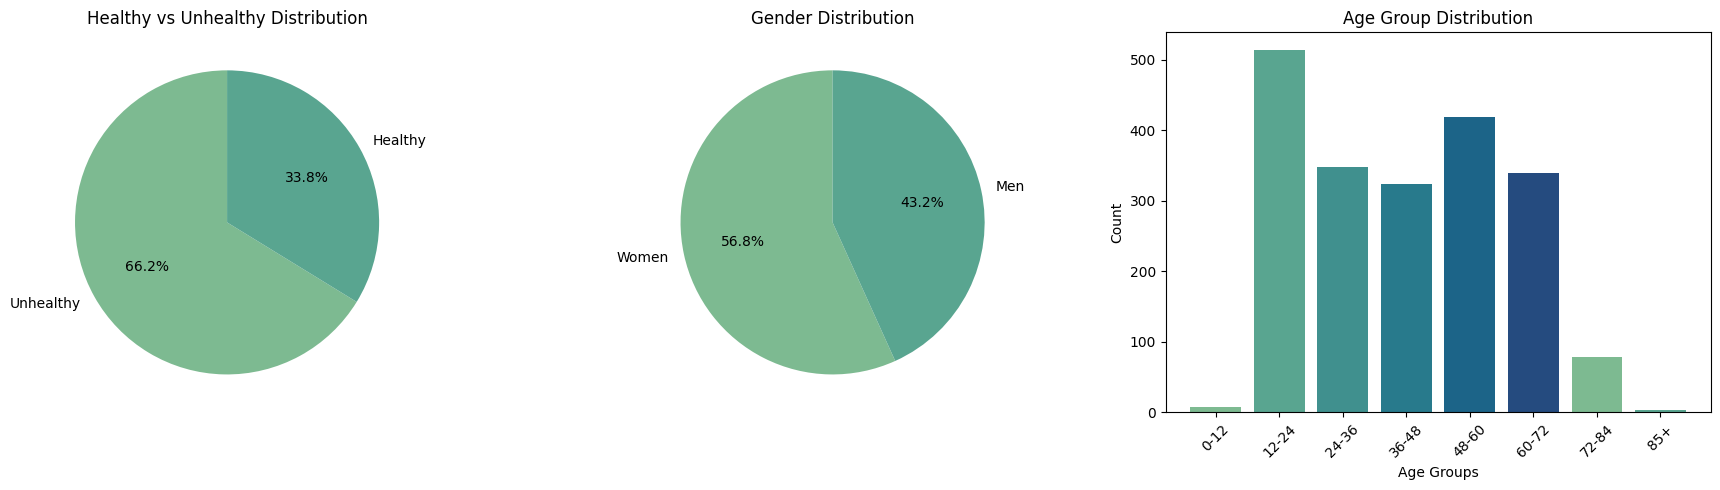

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
crest_palette = sns.color_palette('crest')

# Healthy vs Unhealthy distribution
status_counts = df['status'].value_counts()
axes[0].pie(status_counts.values, labels=status_counts.index,
            autopct='%1.1f%%', startangle=90, colors=crest_palette[:len(status_counts)])
axes[0].set_title('Healthy vs Unhealthy Distribution')

# Gender distribution
gender_counts = df['gender'].value_counts()
gender_labels = ['Women' if g == 'w' else 'Men' for g in gender_counts.index]
axes[1].pie(gender_counts.values, labels=gender_labels,
            autopct='%1.1f%%', startangle=90, colors=crest_palette[:len(gender_counts)])
axes[1].set_title('Gender Distribution')

# Age distribution (bar chart)
age_counts = df['age_group'].value_counts().sort_index()
axes[2].bar(age_counts.index, age_counts.values, color=crest_palette[:len(age_counts)])
axes[2].set_title('Age Group Distribution')
axes[2].set_xlabel('Age Groups')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Distribution of health status in gender and different age brackets

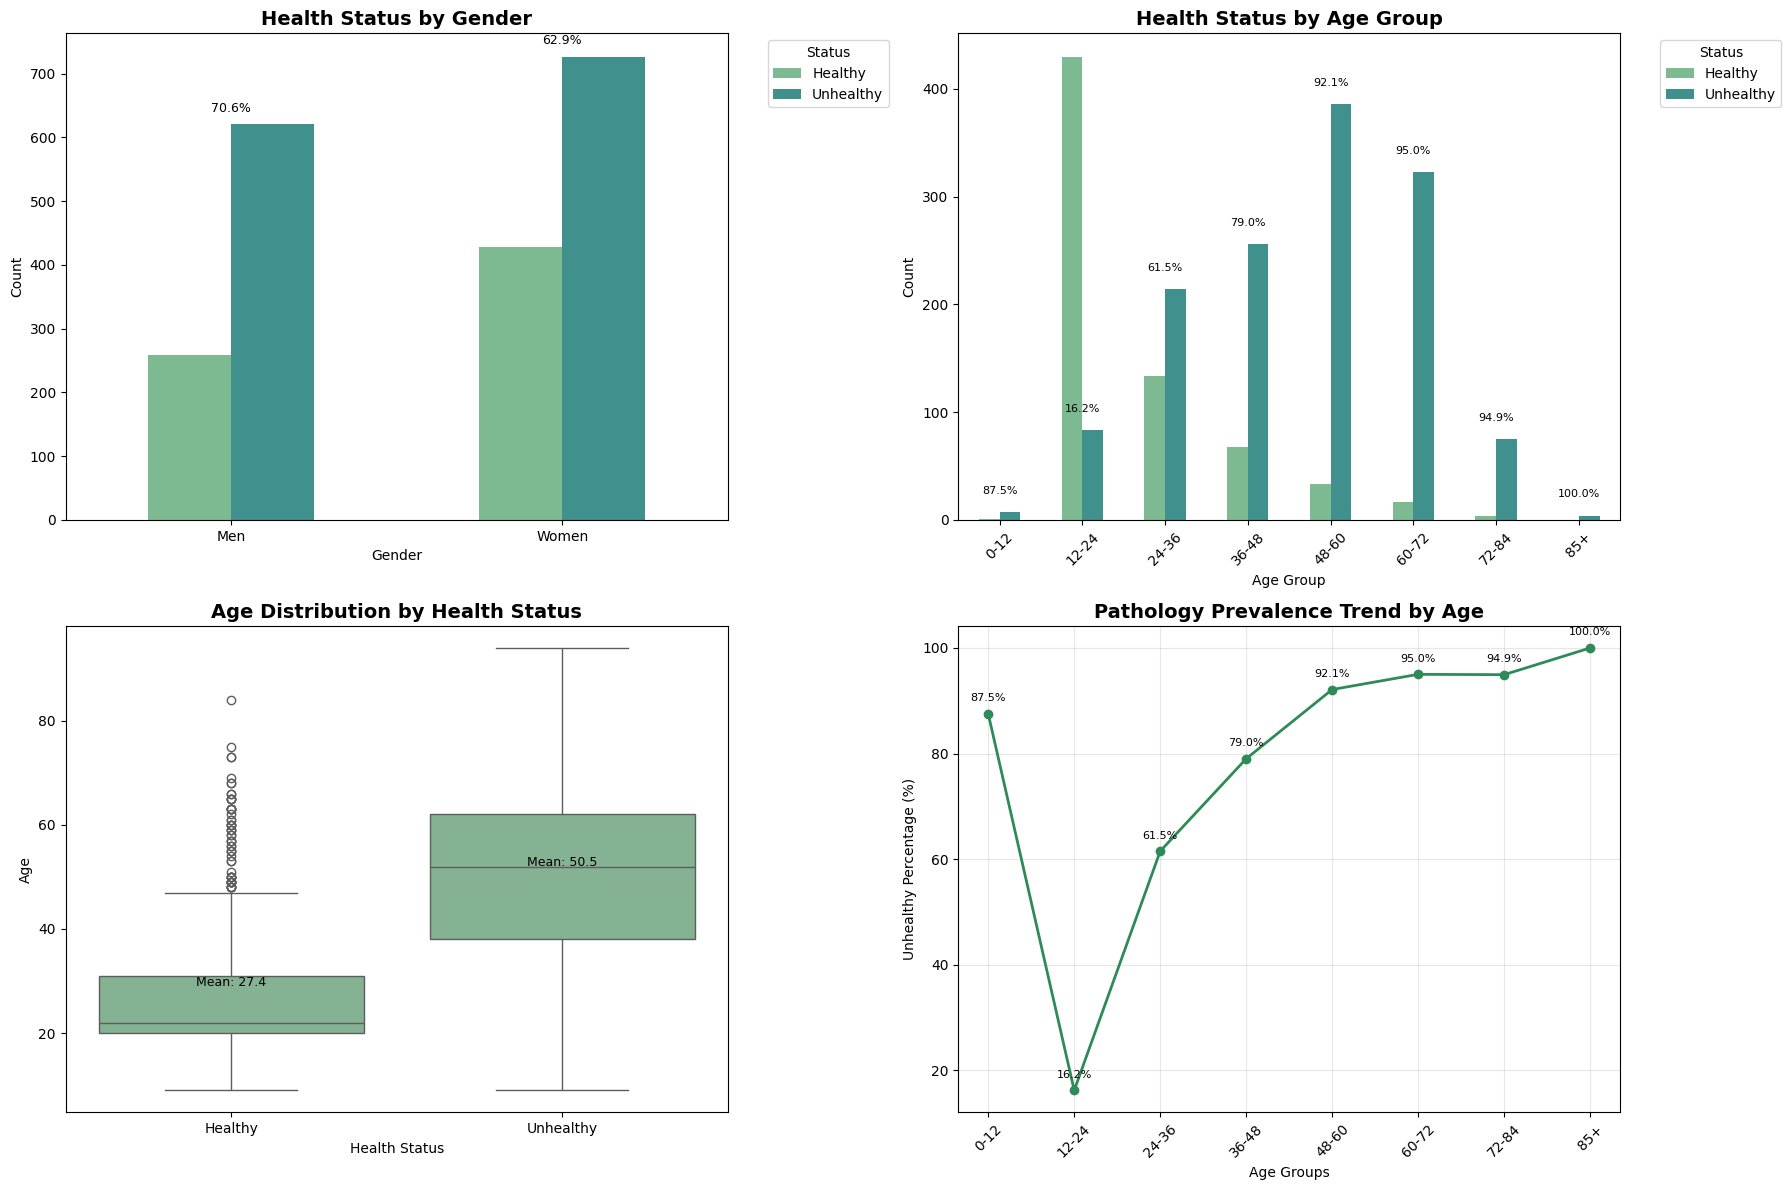

In [53]:
plt.style.use('default')
sns.set_palette("crest")

# Create 4 demographic visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Health status by gender
health_by_gender = pd.crosstab(df['gender'], df['status'])
health_by_gender.index = ['Men' if idx == 'm' else 'Women' for idx in health_by_gender.index]

health_by_gender.plot(kind='bar', ax=axes[0,0], color=sns.color_palette('crest')[::2])
axes[0,0].set_title('Health Status by Gender', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Gender')
axes[0,0].set_ylabel('Count')
axes[0,0].legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,0].tick_params(axis='x', rotation=0)

# Add percentage annotations
total_by_gender = health_by_gender.sum(axis=1)
for i, (idx, row) in enumerate(health_by_gender.iterrows()):
    unhealthy_pct = (row['Unhealthy'] / total_by_gender[idx]) * 100
    axes[0,0].text(i, row['Unhealthy'] + 15, f'{unhealthy_pct:.1f}%',
                ha='center', va='bottom', fontweight='normal', fontsize=9)

# 2. Health status by age group
health_by_age = pd.crosstab(df['age_group'], df['status'])

health_by_age.plot(kind='bar', ax=axes[0,1], color=sns.color_palette('crest')[::2])
axes[0,1].set_title('Health Status by Age Group', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Age Group')
axes[0,1].set_ylabel('Count')
axes[0,1].legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].tick_params(axis='x', rotation=45)

# Add percentage annotations for age groups
total_by_age = health_by_age.sum(axis=1)
for i, (idx, row) in enumerate(health_by_age.iterrows()):
    unhealthy_pct = (row['Unhealthy'] / total_by_age[idx]) * 100
    axes[0,1].text(i, row['Unhealthy'] + 15, f'{unhealthy_pct:.1f}%',
                ha='center', va='bottom', fontweight='normal', fontsize=8)

# 3. Age Distribution by Health Status
sns.boxplot(data=df, x='status', y='age', ax=axes[1,0])
axes[1,0].set_title('Age Distribution by Health Status', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Age')
axes[1,0].set_xlabel('Health Status')

# Add mean age annotations
mean_ages = df.groupby('status')['age'].mean()
for i, status in enumerate(['Healthy', 'Unhealthy']):
    axes[1,0].text(i, mean_ages[status] + 1, f'Mean: {mean_ages[status]:.1f}',
                ha='center', va='bottom', fontweight='normal', fontsize=9)

# 4. Pathology Prevalence Trend by Age using the existing age_group column
age_group_trend = pd.crosstab(df['age_group'], df['status'], normalize='index') * 100

age_group_trend['Unhealthy'].plot(kind='line', marker='o', ax=axes[1,1], linewidth=2, color='#2E8B57')
axes[1,1].set_title('Pathology Prevalence Trend by Age', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Age Groups')
axes[1,1].set_ylabel('Unhealthy Percentage (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Add data point labels
for i, (age_group, value) in enumerate(age_group_trend['Unhealthy'].items()):
    axes[1,1].text(i, value + 2, f'{value:.1f}%',
                  ha='center', va='bottom', fontweight='normal', fontsize=8)

plt.tight_layout()
plt.show()



In [54]:
# Count men and women
gender_counts = df['gender'].value_counts()
print("Gender Distribution:")
print(f"Women: {gender_counts.get('w', 0)}")
print(f"Men: {gender_counts.get('m', 0)}")
print()

# Count people in each age bin
age_counts = df['age_group'].value_counts().sort_index()
print("Age Group Distribution:")
for age_group, count in age_counts.items():
    print(f"{age_group}: {count}")
print()

# Count healthy vs unhealthy
status_counts = df['status'].value_counts()
print("Health Status Distribution:")
print(f"Healthy: {status_counts.get('Healthy', 0)}")
print(f"Unhealthy: {status_counts.get('Unhealthy', 0)}")

Gender Distribution:
Women: 1155
Men: 880

Age Group Distribution:
0-12: 8
12-24: 513
24-36: 348
36-48: 324
48-60: 419
60-72: 340
72-84: 79
85+: 4

Health Status Distribution:
Healthy: 687
Unhealthy: 1348


In [55]:
# Count unhealthy and healthy in each gender
health_by_gender = pd.crosstab(df['gender'], df['status'])
print("Health Status by Gender:")
print(f"Women - Healthy: {health_by_gender.loc['w', 'Healthy']}")
print(f"Women - Unhealthy: {health_by_gender.loc['w', 'Unhealthy']}")
print(f"Men - Healthy: {health_by_gender.loc['m', 'Healthy']}")
print(f"Men - Unhealthy: {health_by_gender.loc['m', 'Unhealthy']}")

Health Status by Gender:
Women - Healthy: 428
Women - Unhealthy: 727
Men - Healthy: 259
Men - Unhealthy: 621


Graphs about the spectral features

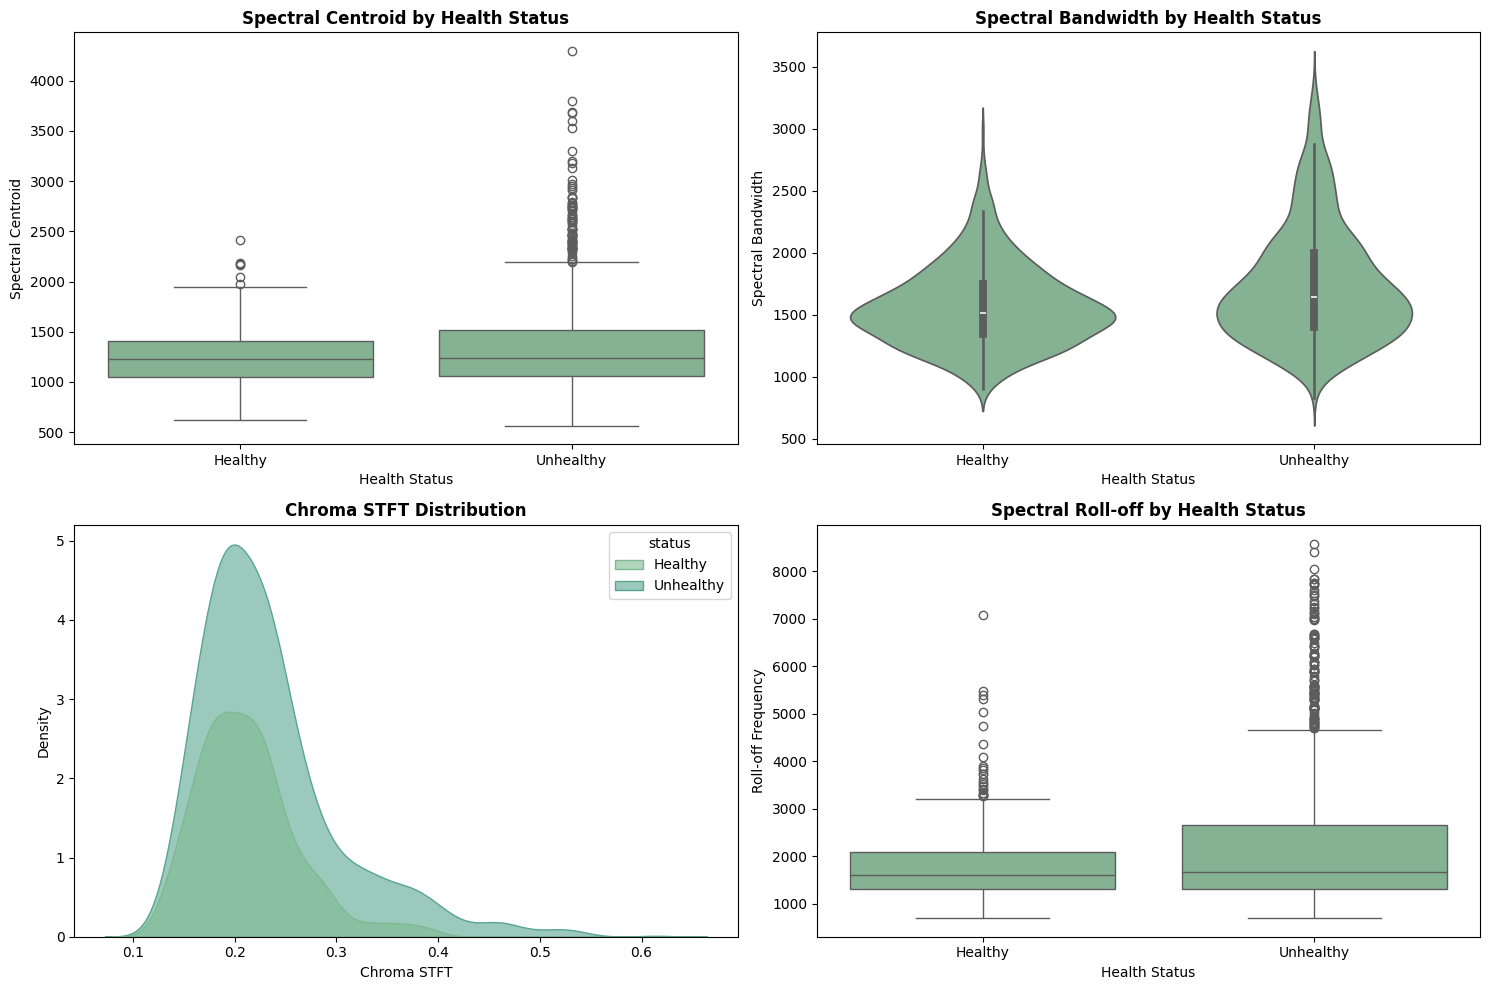

In [56]:
plt.style.use('default')
sns.set_palette("crest")

# Create 4 key spectral feature visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Spectral Centroid Distribution by Health Status
sns.boxplot(data=df, x='status', y='spectral_centroid', ax=axes[0,0])
axes[0,0].set_title('Spectral Centroid by Health Status', fontweight='bold')
axes[0,0].set_xlabel('Health Status')
axes[0,0].set_ylabel('Spectral Centroid')

# 2. Spectral Bandwidth Distribution
sns.violinplot(data=df, x='status', y='spectral_bandwidth', ax=axes[0,1])
axes[0,1].set_title('Spectral Bandwidth by Health Status', fontweight='bold')
axes[0,1].set_xlabel('Health Status')
axes[0,1].set_ylabel('Spectral Bandwidth')

# 3. Chroma STFT Comparison
sns.kdeplot(data=df, x='chroma_stft', hue='status', fill=True, alpha=0.6, ax=axes[1,0])
axes[1,0].set_title('Chroma STFT Distribution', fontweight='bold')
axes[1,0].set_xlabel('Chroma STFT')
axes[1,0].set_ylabel('Density')

# 4. Spectral Roll-off Frequency
sns.boxplot(data=df, x='status', y='rolloff', ax=axes[1,1])
axes[1,1].set_title('Spectral Roll-off by Health Status', fontweight='bold')
axes[1,1].set_xlabel('Health Status')
axes[1,1].set_ylabel('Roll-off Frequency')

plt.tight_layout()
plt.show()

Graphs about the temporal features

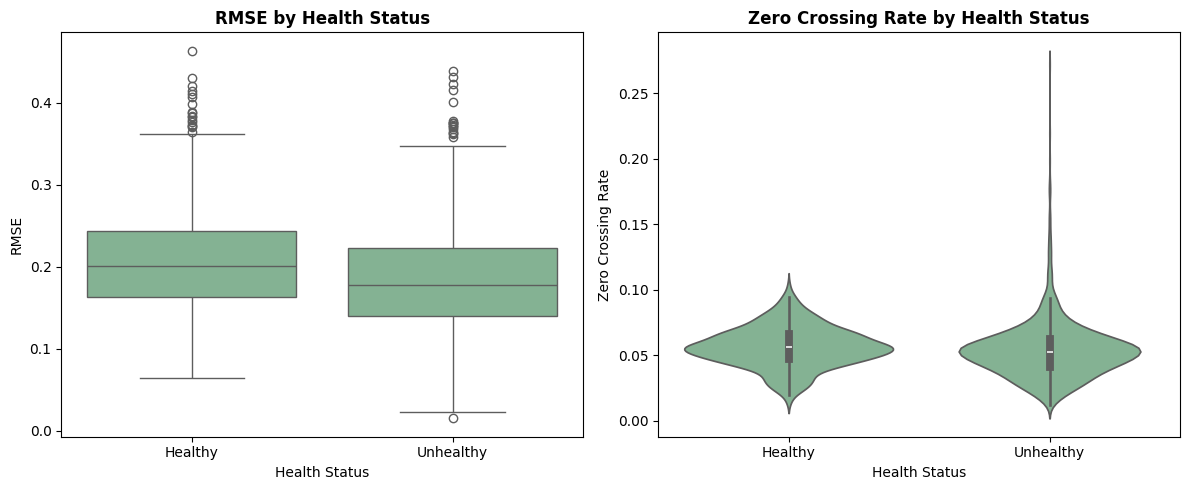

In [57]:
plt.style.use('default')
sns.set_palette("crest")

# Create temporal feature visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. RMSE (Root Mean Square Energy) Distribution
sns.boxplot(data=df, x='status', y='rmse', ax=axes[0])
axes[0].set_title('RMSE by Health Status', fontweight='bold')
axes[0].set_xlabel('Health Status')
axes[0].set_ylabel('RMSE')

# 2. Zero Crossing Rate Distribution
sns.violinplot(data=df, x='status', y='zero_crossing_rate', ax=axes[1])
axes[1].set_title('Zero Crossing Rate by Health Status', fontweight='bold')
axes[1].set_xlabel('Health Status')
axes[1].set_ylabel('Zero Crossing Rate')

plt.tight_layout()
plt.show()

Graphs about the MFCC features

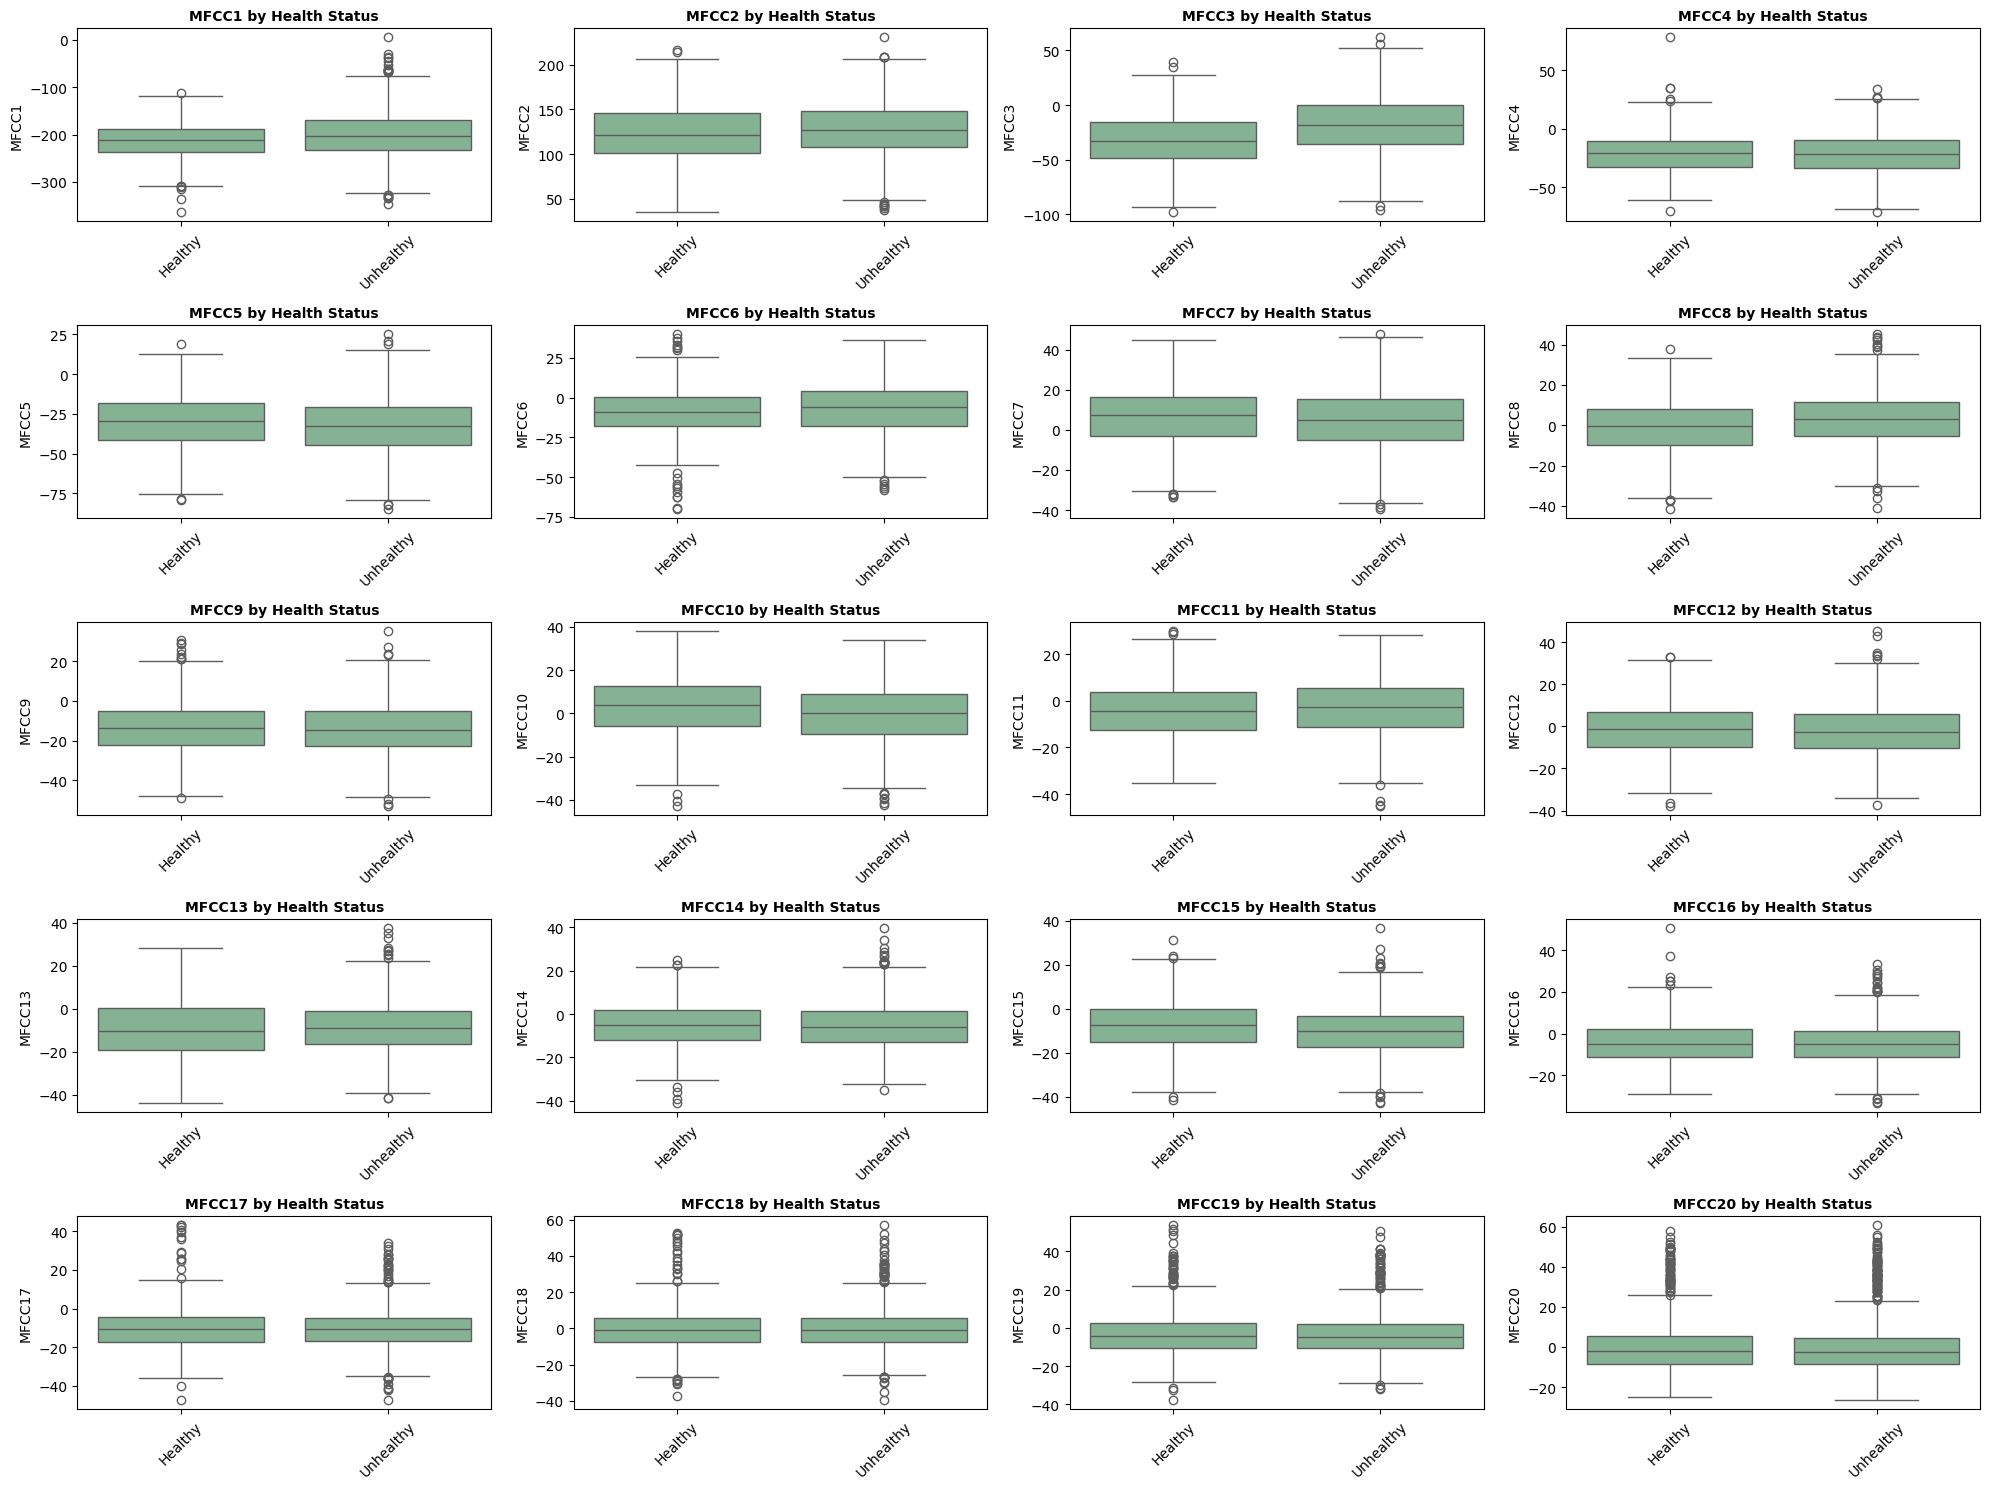

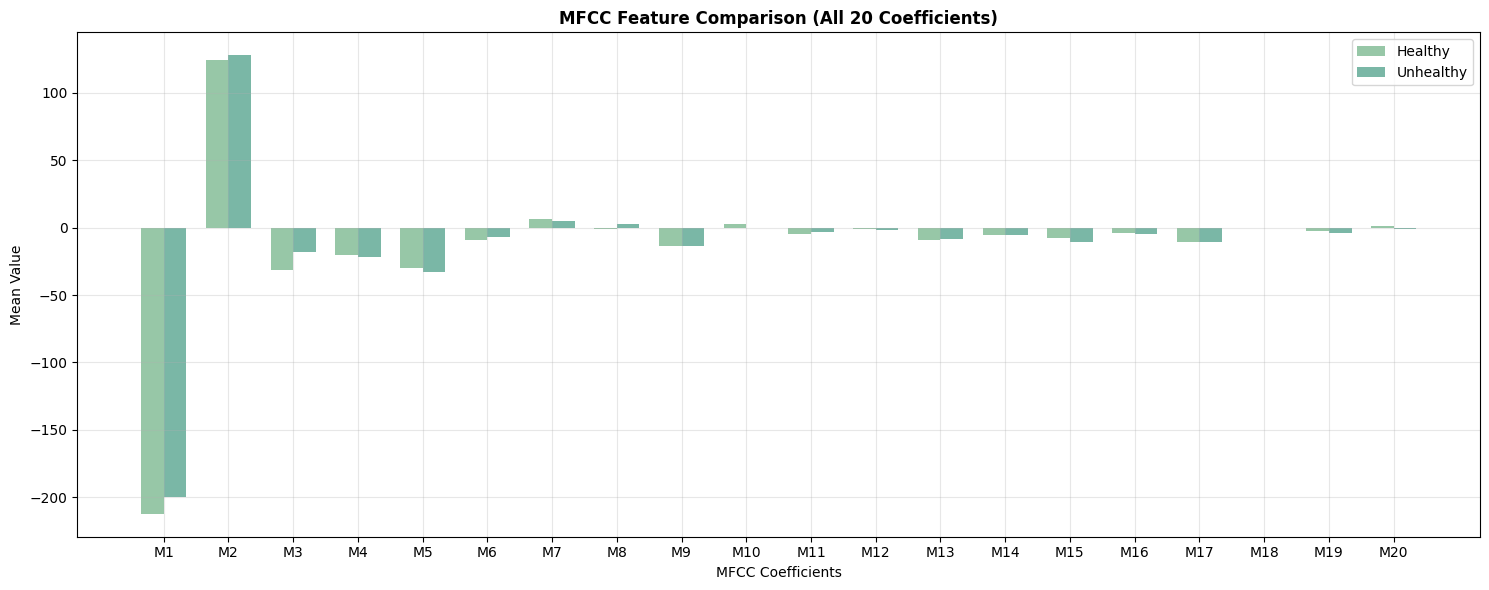

In [58]:
plt.style.use('default')
sns.set_palette("crest")

# Create MFCC feature visualizations for all 20 coefficients
fig, axes = plt.subplots(5, 4, figsize=(20, 15))
axes = axes.flatten()

# Plot all 20 MFCCs as boxplots
for i in range(20):
    feature = f'mfcc{i+1}'
    sns.boxplot(data=df, x='status', y=feature, ax=axes[i])
    axes[i].set_title(f'MFCC{i+1} by Health Status', fontweight='bold', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(f'MFCC{i+1}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. MFCC mean values comparison for all 20 coefficients
fig, ax = plt.subplots(figsize=(15, 6))

mfcc_features = [f'mfcc{i+1}' for i in range(20)]
mfcc_healthy = df[df['status'] == 'Healthy'][mfcc_features].mean()
mfcc_unhealthy = df[df['status'] == 'Unhealthy'][mfcc_features].mean()

x = np.arange(len(mfcc_features))
width = 0.35

bars1 = ax.bar(x - width/2, mfcc_healthy.values, width, label='Healthy', alpha=0.8)
bars2 = ax.bar(x + width/2, mfcc_unhealthy.values, width, label='Unhealthy', alpha=0.8)

ax.set_title('MFCC Feature Comparison (All 20 Coefficients)', fontweight='bold')
ax.set_xlabel('MFCC Coefficients')
ax.set_ylabel('Mean Value')
ax.set_xticks(x)
ax.set_xticklabels([f'M{i+1}' for i in range(20)])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Graphs about features interacting with one another

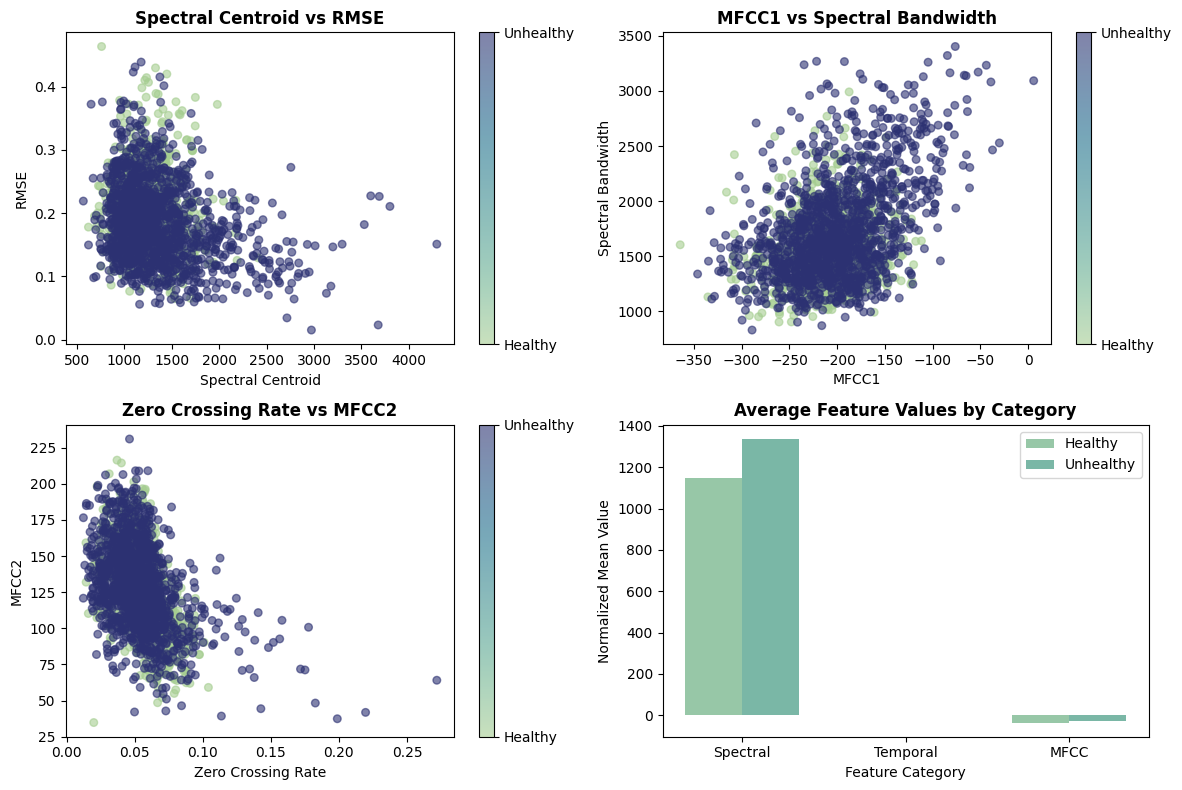

In [59]:
plt.style.use('default')
sns.set_palette("crest")

# Create mixed feature visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Spectral vs Temporal: Spectral Centroid vs RMSE
scatter1 = axes[0,0].scatter(df['spectral_centroid'], df['rmse'],
                            c=df['status'].map({'Healthy': 0, 'Unhealthy': 1}),
                            cmap='crest', alpha=0.6, s=30)
axes[0,0].set_title('Spectral Centroid vs RMSE', fontweight='bold')
axes[0,0].set_xlabel('Spectral Centroid')
axes[0,0].set_ylabel('RMSE')
cbar1 = plt.colorbar(scatter1, ax=axes[0,0])
cbar1.set_ticks([0, 1])
cbar1.set_ticklabels(['Healthy', 'Unhealthy'])

# 2. MFCC vs Spectral: MFCC1 vs Spectral Bandwidth
scatter2 = axes[0,1].scatter(df['mfcc1'], df['spectral_bandwidth'],
                            c=df['status'].map({'Healthy': 0, 'Unhealthy': 1}),
                            cmap='crest', alpha=0.6, s=30)
axes[0,1].set_title('MFCC1 vs Spectral Bandwidth', fontweight='bold')
axes[0,1].set_xlabel('MFCC1')
axes[0,1].set_ylabel('Spectral Bandwidth')
cbar2 = plt.colorbar(scatter2, ax=axes[0,1])
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['Healthy', 'Unhealthy'])

# 3. Temporal vs MFCC: Zero Crossing Rate vs MFCC2
scatter3 = axes[1,0].scatter(df['zero_crossing_rate'], df['mfcc2'],
                            c=df['status'].map({'Healthy': 0, 'Unhealthy': 1}),
                            cmap='crest', alpha=0.6, s=30)
axes[1,0].set_title('Zero Crossing Rate vs MFCC2', fontweight='bold')
axes[1,0].set_xlabel('Zero Crossing Rate')
axes[1,0].set_ylabel('MFCC2')
cbar3 = plt.colorbar(scatter3, ax=axes[1,0])
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['Healthy', 'Unhealthy'])

# 4. Feature type comparison: Mean values by category
feature_categories = {
    'Spectral': ['spectral_centroid', 'spectral_bandwidth', 'chroma_stft', 'rolloff'],
    'Temporal': ['rmse', 'zero_crossing_rate'],
    'MFCC': ['mfcc1', 'mfcc2', 'mfcc3', 'mfcc4']
}

category_means_healthy = []
category_means_unhealthy = []
categories = []

for category, features in feature_categories.items():
    healthy_mean = df[df['status'] == 'Healthy'][features].mean().mean()
    unhealthy_mean = df[df['status'] == 'Unhealthy'][features].mean().mean()
    category_means_healthy.append(healthy_mean)
    category_means_unhealthy.append(unhealthy_mean)
    categories.append(category)

x = np.arange(len(categories))
width = 0.35

bars1 = axes[1,1].bar(x - width/2, category_means_healthy, width, label='Healthy', alpha=0.8)
bars2 = axes[1,1].bar(x + width/2, category_means_unhealthy, width, label='Unhealthy', alpha=0.8)

axes[1,1].set_title('Average Feature Values by Category', fontweight='bold')
axes[1,1].set_xlabel('Feature Category')
axes[1,1].set_ylabel('Normalized Mean Value')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(categories)
axes[1,1].legend()

plt.tight_layout()
plt.show()

Heatmap of the Key Features

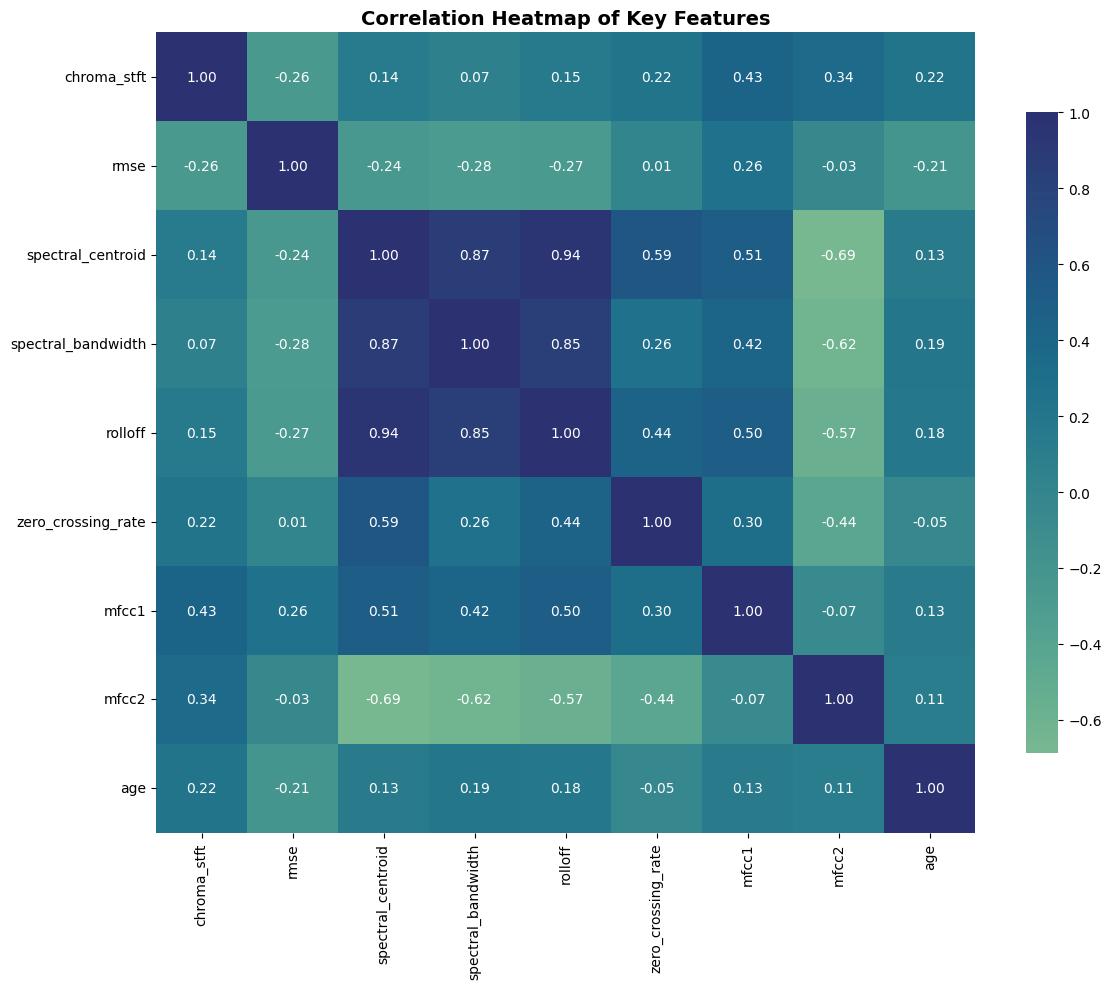

In [60]:
selected_features = ['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
                    'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'age']
correlation_matrix = df[selected_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', center=0, fmt='.2f',
            cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap of Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Machine Learning

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [78]:
# Prepare features and target
features = ['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
           'rolloff', 'zero_crossing_rate'] + [f'mfcc{i}' for i in range(1, 21)] + ['gender_encoded', 'age']

X = df[features]
y = df['status'] # The target is ['Healthy' and 'Unhealthy']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [79]:
# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert string labels to numerical values
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Check the mapping
print("Label mapping:")
for i, label in enumerate(le.classes_):
    print(f"  {i} -> {label}")

Label mapping:
  0 -> Healthy
  1 -> Unhealthy


In [80]:
# Initialize models
models = {
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Store results
results = []

# Train and evaluate models
for name, model in models.items():
    # Select scaled or unscaled data
    if name in ['Logistic Regression', 'K-Nearest Neighbors']:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        X_train_used = X_train
        X_test_used = X_test

    # Train model
    model.fit(X_train_used, y_train_encoded)

    # Make predictions
    y_pred = model.predict(X_test_used)

    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')

    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)

# Print results
print("MODEL PERFORMANCE COMPARISON")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 60)
for _, row in results_df.iterrows():
    print(f"{row['Model']:<20} {row['Accuracy']:<10.3f} {row['Precision']:<10.3f} {row['Recall']:<10.3f} {row['F1-Score']:<10.3f}")


# Print best model
best_model = results_df.iloc[0]
print(f"\nBEST MODEL: {best_model['Model']}")
print(f"F1-Score: {best_model['F1-Score']:.3f}")
print(f"Accuracy: {best_model['Accuracy']:.3f}")

MODEL PERFORMANCE COMPARISON
Model                Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
XGBoost              0.853      0.852      0.853      0.852     
Random Forest        0.843      0.840      0.843      0.841     
Logistic Regression  0.823      0.827      0.823      0.825     
Decision Tree        0.769      0.768      0.769      0.769     
K-Nearest Neighbors  0.744      0.744      0.744      0.744     

BEST MODEL: XGBoost
F1-Score: 0.852
Accuracy: 0.853


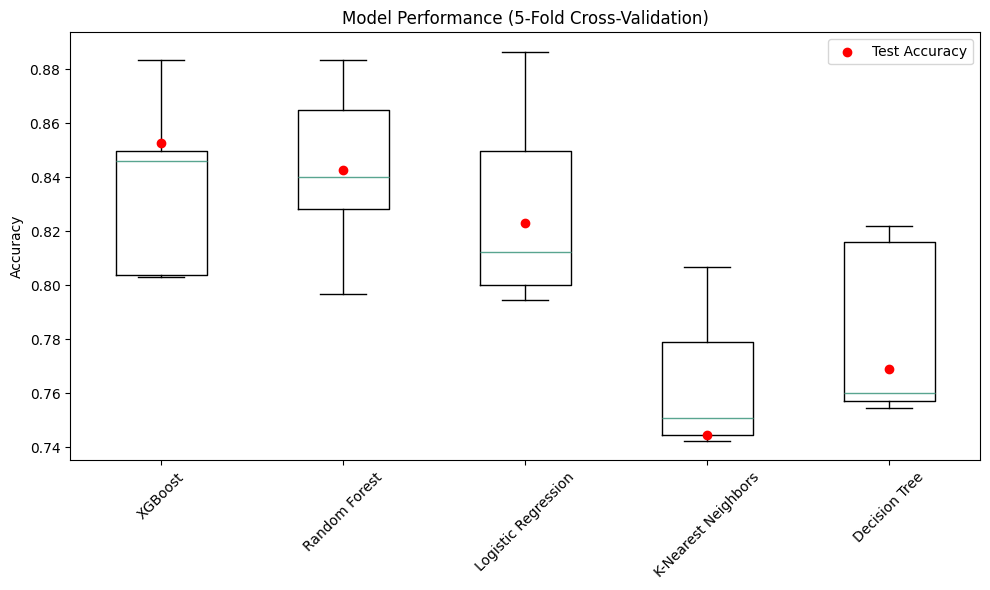

In [82]:
# Box plot with cross-validation scores
plt.figure(figsize=(10, 6))

cv_results = {}
for name, model in models.items():
    # Select scaled or unscaled data for CV
    if name in ['Logistic Regression', 'K-Nearest Neighbors']:
        X_used = X_train_scaled
    else:
        X_used = X_train

    # Perform cross-validation
    from sklearn.model_selection import cross_val_score
    cv_scores = cross_val_score(model, X_used, y_train_encoded, cv=5, scoring='accuracy')
    cv_results[name] = cv_scores

# Create box plot
boxplot_data = [cv_results[name] for name in models.keys()]
plt.boxplot(boxplot_data, labels=models.keys())
plt.title('Model Performance (5-Fold Cross-Validation)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Add test accuracy points from our results
for i, row in results_df.iterrows():
    plt.scatter(i + 1, row['Accuracy'], color='red', zorder=3,
                label='Test Accuracy' if i == 0 else "")

plt.legend()
plt.tight_layout()
plt.show()